In [170]:
import Tom_Model as TM
import pandas as pd
import numpy as np
import random

from collections import defaultdict
from copy import deepcopy

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import matplotlib.pyplot as plt
from pandas.plotting import table
import matplotlib.colors as cl

from collections import Counter

from tabulate import tabulate

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import itertools

In [171]:
theta = 1.7

In [172]:
iterations = 1

In [173]:
init_table_file = 'CNL_initial.csv'
#current_table_file = 'CONMEBOL_current.csv'

init_sched_file = 'CNL_schedule.csv'
#current_sched_file = 'CONMEBOL_schedule_current.csv'

In [174]:
host = "United_States"

In [175]:
quals_group_table = pd.read_csv(init_table_file, header=0)

matches = pd.read_csv(init_sched_file, header=0)

In [176]:
quals_group_table = quals_group_table.set_index('Code')

init_group_table = deepcopy(quals_group_table)

In [177]:
finish_table = pd.DataFrame(0,
                            index = Counter(quals_group_table.index).keys(),
                            columns = ['Final', 'Winner'])

In [178]:
r1_SF = matches[matches['Group'] == 'SF']
r1_F = matches[matches['Group'] == 'F']

In [183]:
for iteration in range(iterations):
    
    for match in range(2):
        
        #calculate win expectancies
        home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(r1_SF, 
                                                                       match, quals_group_table, host)
        
        #Determine win probability for each team
        home_wp = TM.davidson_home_wp(home_we, away_we, theta)
        away_wp = TM.davidson_away_wp(home_we, away_we, theta)
        draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)
        
        print(f"{home_team} / Draw / {away_team}")
        print(f"{home_wp} / {draw_wp} / {away_wp}")

    
        quals_group_table, r1_SF = TM.play_ko_match_neutral(quals_group_table, r1_SF, match,
                                  home_team, home_we, home_elo, home_wp, 
                                  away_team, away_we, away_elo, away_wp, draw_wp)
        
        
    SF1_winner = r1_SF.loc[0, 'Winner']
    SF2_winner = r1_SF.loc[1, 'Winner']
    
    r1_F.loc[2, 'Home'] = SF1_winner
    r1_F.loc[2, 'Away'] = SF2_winner
    
    finish_table.loc[SF1_winner, 'Final'] += 1
    finish_table.loc[SF2_winner, 'Final'] += 1
    
    #calculate win expectancies
    home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(r1_F, 
                                                                       2, quals_group_table, host)
    
    #Determine win probability for each team
    home_wp = TM.davidson_home_wp(home_we, away_we, theta)
    away_wp = TM.davidson_away_wp(home_we, away_we, theta)
    draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)
    
    print(f"{home_team} / Draw / {away_team}")
    print(f"{home_wp} / {draw_wp} / {away_wp}")


    quals_group_table, r1_F = TM.play_ko_match_neutral(quals_group_table, r1_F, 2,
                              home_team, home_we, home_elo, home_wp, 
                              away_team, away_we, away_elo, away_wp, draw_wp)
    
    tourney_winner = r1_F.loc[2, 'Winner']
    finish_table.loc[tourney_winner, 'Winner'] += 1
    
    quals_group_table = deepcopy(init_group_table)
    
    print(f'Iteration {iteration+1} / {iterations}')

United_States / Draw / Jamaica
0.6995521904057297 / 0.1710645489709549 / 0.12938326062331532
Mexico / Draw / Panama
0.4086745814371261 / 0.257694691625762 / 0.333630726937112
Jamaica / Draw / Panama
0.20524941759655402 / 0.2221312807422545 / 0.5726193016611915
Iteration 1 / 1


/Users/thomasgaudin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [180]:
finish_table

,Final,Winner
United_States,1,1
Jamaica,0,0
Mexico,1,0
Panama,0,0


In [181]:
sorted_finish = finish_table.sort_values('Winner', ascending=False) / iterations

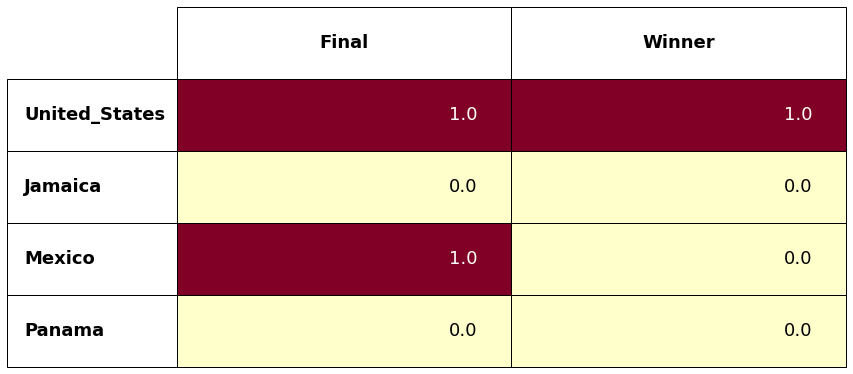

In [182]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=sorted_finish.values, cellColours=plt.cm.YlOrRd(sorted_finish.values),
                 rowLabels=sorted_finish.index, colLabels=sorted_finish.columns, 
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(2, 6)

table_props = table.properties()
table_cells = table_props['children']
for cell in table_cells:
    if sum(cell.properties()['facecolor']) < sum(cl.to_rgba('0.43')):
        cell.get_text().set_color('white')

# ab = AnnotationBbox(getImage("./country-flags-main/png1000px/ar.png"), (200, 1837), 
#                     frameon=False, xycoords='figure points')
# ax.add_artist(ab)


for val in range(0,2):
    head = table[0,val]
    head.set_text_props(fontsize=18, fontweight='bold', verticalalignment='center')

for val in range(1,5):
    head = table[val,-1]
    head.set_text_props(fontsize=18, fontweight='bold', verticalalignment='center')

    
plt.show()